In [45]:
import numpy as np
from scipy import integrate, optimize
from scipy.constants import e, c, alpha, m_e, hbar

from matplotlib import pyplot as plt

data = np.genfromtxt("./data.csv", delimiter=",")[1::] # Exclude headers

THETA = data[:,0] / 180.0 * np.pi # radians
Y = data[:,1] * 1e-31 # m^2/sr
ERROR = data[:,2] * 1e-31 # m^2/sr

In [98]:
Z = 20
epsilon = 1e-6
E = 250e6 * e
beta = np.sqrt(1-((m_e*c**2)/E)**2)
p = m_e*beta*c/np.sqrt(1-beta**2)

trap_X = np.linspace(0, 15e-15, 10000)

# Assumes SI-units
# ---------------------
def rho_ch(r,X):
    rho_0, a, b = X[0], X[1], X[2]
    return rho_0 / ( 1 + np.exp((r-a)/b))

def F_integrand(r,q,X):
    return r * rho_ch(r,X) * np.sin(q*r/hbar)

def chi_integrand(r,X):
    return r**2 * rho_ch(r,X)

def integral_chi(X):
    y = chi_integrand(trap_X, X)
    value = integrate.trapezoid(y, x=trap_X)
    return value

def integral_F(q, X):
    y = F_integrand(trap_X, q, X)
    value = integrate.trapezoid(y, x=trap_X)
    return value

def J(theta, X):
    mott = (Z*alpha*c*hbar/(2*beta**2*E*(np.sin(theta/2))**2))**2 * (1 - beta**2 * (np.sin(theta/2))**2)
    q = 2 * p * np.sin(theta/2)
    F = 4 * np.pi / (Z * e * q) * integral_F(q, X)
    return mott * np.abs(F)**2
# ---------------------

In [111]:
def X_to_SI(X):
    # [rho_0] = e / fm^3
    # [a] = fm
    # [b] = fm
    return X * np.array([e / 1e-15 ** 3, 1e-15, 1e-15])

def chi2(X_nuc):
    S = 0
    X = X_to_SI(X_nuc)
    plt.plot(trap_X, chi_integrand(trap_X, X))
    # print(X_nuc)
    constraint = ((Z - (4 * np.pi / e) * integral_chi(X)) / epsilon) ** 2
    #print(4*np.pi/e)
    #print(constraint)
    for theta, y, error in zip(THETA, Y, ERROR):
        S += ((J(theta, X) - y) / error) ** 2 + constraint
    return S

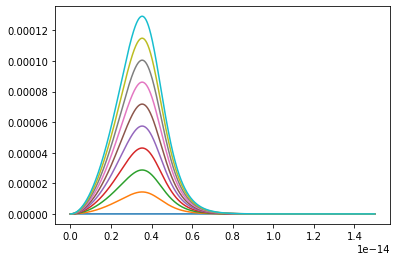

In [112]:

for x in range(0,10):
    chi2(np.array([x*0.01, 4, 0.5]))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83977+140    |proj g|=  1.00000D+00

At iterate    1    f=  1.81474+139    |proj g|=  2.00000D+00

At iterate    2    f=  2.76586+138    |proj g|=  1.31318D+00

At iterate    3    f=  2.75424+138    |proj g|=  1.30705D+00

At iterate    4    f=  2.74628+138    |proj g|=  1.30201D+00

At iterate    5    f=  2.74080+138    |proj g|=  1.29784D+00

At iterate    6    f=  2.73701+138    |proj g|=  1.29439D+00

At iterate    7    f=  2.73439+138    |proj g|=  1.29153D+00

At iterate    8    f=  2.73257+138    |proj g|=  1.28916D+00

At iterate    9    f=  2.73131+138    |proj g|=  1.28718D+00

At iterate   10    f=  2.73044+138    |proj g|=  1.28554D+00

At iterate   11    f=  2.72983+138    |proj g|=  1.28417D+00

At iterate   12    f=  2.72940+138    |proj g|=  1.28303D+00

At iterate   13    f=  2.7

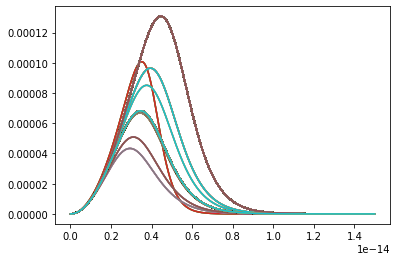

In [113]:
res = optimize.minimize(chi2, [0.066, 4, 0.4], tol=1e-16, bounds=[(0.06,0.08),(3,5),(0.3,0.7)], options={"disp":True})

print(res.x)

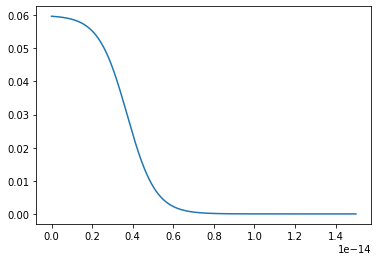

In [114]:
plt.plot(trap_X, rho_ch(trap_X, X_to_SI(res.x))/e*1e-15**3)